Function which tries to detect location of occlusion in a curve and displays the different possible closed figures in the curve

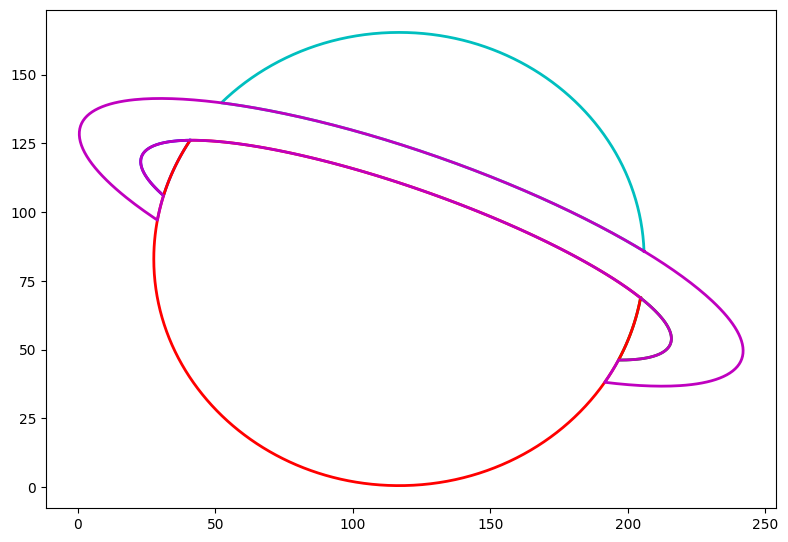

In [16]:
import numpy as np

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

csv_file_path = '/content/occlusion2.csv'
shape_paths = read_csv(csv_file_path)

import numpy as np
import matplotlib.pyplot as plt

def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Different colors for different paths
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()
plot(shape_paths)

In [17]:
from shapely.geometry import LineString

def detect_occlusions(paths_XYs):
    occlusions = []
    for i, path in enumerate(paths_XYs):
        for j, segment in enumerate(path):
            line_segment = LineString(segment)
            for k, other_path in enumerate(paths_XYs):
                if i == k:  # Skip self-comparison
                    continue
                for l, other_segment in enumerate(other_path):
                    other_line_segment = LineString(other_segment)
                    if line_segment.intersects(other_line_segment):
                        occlusions.append((i, j, k, l))
    return occlusions

# Example usage
occlusions = detect_occlusions(shape_paths)
print("Detected occlusions:", occlusions)


Detected occlusions: [(0, 0, 2, 0), (0, 0, 4, 0), (1, 0, 2, 0), (1, 0, 4, 0), (2, 0, 0, 0), (2, 0, 1, 0), (2, 0, 4, 0), (3, 0, 4, 0), (4, 0, 0, 0), (4, 0, 1, 0), (4, 0, 2, 0), (4, 0, 3, 0)]


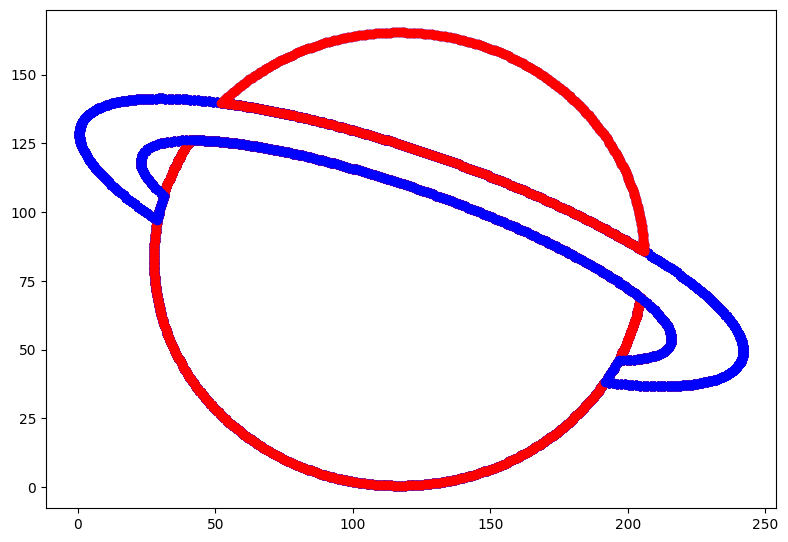

In [18]:
def plot_with_occlusions(paths_XYs, occlusions):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Different colors for different paths

    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    # Plot detected occlusions (for visualization, you may use a different style)
    for (i, j, k, l) in occlusions:
        segment_i = paths_XYs[i][j]
        segment_k = paths_XYs[k][l]
        ax.plot(segment_i[:, 0], segment_i[:, 1], 'bo--', linewidth=2)  # Highlight with different style
        ax.plot(segment_k[:, 0], segment_k[:, 1], 'ro--', linewidth=2)  # Highlight with different style

    ax.set_aspect('equal')
    plt.show()

# Example usage
plot_with_occlusions(shape_paths, occlusions)


In [28]:
def preprocess_data(segment):
    if len(segment) > 1:
        x = segment[:, 0]
        y = segment[:, 1]

        # Sort by x values
        sorted_indices = np.argsort(x)
        x = x[sorted_indices]
        y = y[sorted_indices]

        # Remove duplicate x values
        unique_indices = np.unique(x, return_index=True)[1]
        x = x[unique_indices]
        y = y[unique_indices]

        return x, y
    return None, None


In [29]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def complete_occluded_segments(occluded_segments):
    completed_segments = []

    for segment in occluded_segments:
        x, y = preprocess_data(segment)
        if x is not None and y is not None:
            # Use interp1d for interpolation
            f = interp1d(x, y, kind='linear', fill_value="extrapolate")
            x_new = np.linspace(x.min(), x.max(), 100)
            y_new = f(x_new)
            completed_segment = np.column_stack((x_new, y_new))
            completed_segments.append(completed_segment)

    return completed_segments

def plot_segments(segments, title):
    plt.figure(figsize=(8, 8))
    for segment in segments:
        plt.plot(segment[:, 0], segment[:, 1], 'b-', linewidth=2)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

# Example usage
completed_occluded_segments = complete_occluded_segments(occluded_segments)
plot_segments(completed_occluded_segments, 'Completed Curves')
